# Shared Task
## Preparations

In [1]:
import pandas as pd
import spacy
import os
import csv
import nltk

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('wordnet')
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from nltk.corpus import wordnet as wn
from tqdm import tqdm_notebook as tqdm
from pprint import pprint
from spacy import displacy
from enum import Enum
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import cross_val_score, GridSearchCV


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/seungbinyim/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
nlp = spacy.load('en_core_web_lg')
pd.set_option('display.max_colwidth',-1)
def print_all_rows(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        print(df)

**LOAD DATA**

In [7]:
folder = 'data/train'

def lemmatizer(doc):
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)


def remove_stopwords(doc):
    # This will remove stopwords and punctuation.
    # Use token.text to return strings, which we'll need for Gensim.
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return doc


def has_label(df, label):
    return df['relation'] == label


def filter_small_length(dataset, threshold):
    return len(dataset.index) > threshold


def sort(lst):
    return sorted(lst, key=len)


def upsample_from_bigger_set(smallest_by_label, bigger_by_label):
    biggeset_label, biggest_label_size = find_biggest_label_and_size(smallest_by_label)

    return upsample_by_diff(bigger_by_label, biggeset_label, biggest_label_size, smallest_by_label)


def upsample_by_diff(bigger_by_label, biggeset_label, biggest_label_size, smallest_by_label):
    for key in smallest_by_label:
        if key != biggeset_label:
            diff = biggest_label_size - len(smallest_by_label[key].index)
            if diff > 0:
                new_data = bigger_by_label[key].sample(n=diff, random_state=7, replace=True)
                smallest_by_label[key] = smallest_by_label[key].append(new_data)

    return smallest_by_label


def find_biggest_label_and_size(smallest_by_label):
    largest_label = None
    largest_label_size = 0

    for key in smallest_by_label:
        if len(smallest_by_label[key].index) > largest_label_size:
            largest_label_size = len(smallest_by_label[key].index)
            largest_label = key

    return largest_label, largest_label_size


def combine_labels(dict_by_label):
    df = pd.DataFrame()

    for key in dict_by_label:
        df = df.append(dict_by_label[key])

    return df.sample(frac=1, random_state=7)


def sort_dataset(all_data, dataset_lang):
    lang_data = []
    for key in all_data.keys():
        if dataset_lang in key:
            lang_data.append(all_data[key])
    sorted_sets = list(filter(lambda elem: filter_small_length(elem, 100), sort(lang_data)))
    return sorted_sets


def categorize_by_label(df):
    relation_labels = df['relation'].unique()
    smallest_by_label = {}
    for relation in relation_labels:
        smallest_by_label[relation] = df[has_label(df, relation)]

    return smallest_by_label

def load_and_preprocess(dataset_lang, balancing = 'oversampling'):
    all_data = load_training_data()

    sorted_sets = sort_dataset(all_data, dataset_lang)

    balanced = balance_dataset(sorted_sets, balancing)

    balanced['processed_1'] = balanced['def1'].map(nlp)
    balanced['processed_2'] = balanced['def2'].map(nlp)

    balanced['lemmatized_1'] = balanced['processed_1'].map(lemmatizer)
    balanced['stopwords_removed_1'] = balanced['lemmatized_1'].map(remove_stopwords)

    balanced['lemmatized_2'] = balanced['processed_2'].map(lemmatizer)
    balanced['stopwords_removed_2'] = balanced['lemmatized_2'].map(remove_stopwords)

    return balanced

def load_training_data():
    combined_set = {}

    for filename in os.listdir(folder):
        if filename.endswith(".tsv"):
            combined_set[filename.split('.')[0]] = load_data(folder + '/' + filename)

    return combined_set

def load_data(file_path):
    loaded_data = pd.read_csv(file_path, sep='\t', header=None)
    add_column_names(loaded_data)

    return loaded_data

def add_column_names(df):
    column_names = ['word', 'pos', 'def1', 'def2', 'relation']
    df.columns = column_names

def undersample_dataset(imbalanced_set):
    none = imbalanced_set[has_label(imbalanced_set, 'none') == True]
    second_biggest = imbalanced_set.groupby('relation').count().word.sort_values(ascending=False)[1]
    result = imbalanced_set.drop(none.index[second_biggest:])

    return result.sample(frac=1, random_state=7)


def balance_dataset(sorted_sets, balancing):
    if balancing == 'undersampling':
        result = undersample_dataset(sorted_sets[0])

    else:
        smallest = sorted_sets[0]
        bigger = sorted_sets[1]

        smallest_by_label = categorize_by_label(smallest)
        bigger_by_label = categorize_by_label(bigger)

        result = combine_labels(upsample_from_bigger_set(smallest_by_label, bigger_by_label))

    return result


def is_not_none(df):
    return df['relation'] != 'none'


def is_none(df):
    return df['relation'] == 'none'

In [8]:
balanced_en_data = load_and_preprocess('english', balancing = 'oversampling')
balanced_en_data_undersampled = load_and_preprocess('english', balancing = 'undersampling')

**Define Feature Extraction related functions**

In [9]:

def first_word_same(row):
    return row['def1'].split(' ')[0].lower() == row['def2'].split(' ')[0].lower()


def difference_in_length(row):
    return abs(len(row['def1'].split(' ')) - len(row['def2'].split(' ')[0]))


def jaccard_sim(row):
    return get_jaccard_sim(row['def1'], row['def2'])


def cosine(row):
    return get_cosine_sim(row['def1'], row['def2'])[0, 1]



def get_vectors(*strs):
    text = [t for t in strs]
    vectorizer = CountVectorizer(text)
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray()

def pos_count(column):
    pos = []
    
    for token in column:
        pos.append(token.pos)
    return list(set(pos))
        
    
def diff_pos_count(row):
    pos_def1 = pos_count(row['processed_1'])
    pos_def2 = pos_count(row['processed_2'])
    
    return  len(pos_def1) - len(pos_def2)
    
def tfidf(col1, col2):
    tfidf_holder = pd.DataFrame()
    tfidf_holder['col1'] = col1
    tfidf_holder['col2'] = col2

    values = join_definitions(col1, col2)
    tfidf_holder['tfidf_1'], tfidf_holder['tfidf_2'] = tfidf_vectors(values)

    return tfidf_holder.apply(lambda row: cosine_similarity([row['tfidf_1'], row['tfidf_2']])[0, 1], axis=1)


def convert_to_text(token_array):
    seperator = ' '
    return seperator.join(token_array)


def join_definitions(col1, col2):
    joined_definitions = pd.concat([col1, col2])
    return joined_definitions.apply(lambda tokens: ' '.join(tokens)).values.T


def tfidf_vectors(values):
    tfidf_matrix = TfidfVectorizer().fit_transform(values)

    split_index = int(tfidf_matrix.get_shape()[0] / 2)
    tfidf_array = tfidf_matrix.todense()

    df_result1 = [row.tolist()[0] for row in tfidf_array[0:split_index]]
    df_result2 = [row.tolist()[0] for row in tfidf_array[split_index:]]

    return df_result1, df_result2



def extract_features(data, feats_to_scale):
    def sentence2vec(row):
        return row['processed_1'].similarity(row['processed_2'])

    feat = pd.DataFrame()
    print(data)
    feat['similarities'] = data.apply(lambda row: sentence2vec(row), axis=1)
    feat['first_word_same'] = data.apply(lambda row: first_word_same(row), axis=1)
    feat['len_diff'] = data.apply(lambda row: difference_in_length(row), axis=1)
    feat['jaccard'] = data.apply(lambda row: jaccard_sim(row), axis=1)
    feat['cos'] = data.apply(lambda row: cosine(row), axis=1)
    feat['diff_pos_count'] = data.apply(lambda row: diff_pos_count(row), axis = 1)
    feat['tfidf_similarity'] = tfidf(data['stopwords_removed_1'], data['stopwords_removed_2'])

    for c_name in feats_to_scale:
        feat[c_name] = preprocessing.scale(feat[c_name])

    return feat


def get_cosine_sim(*strs):
    vectors = [t for t in get_vectors(*strs)]
    return cosine_similarity(vectors)


def get_jaccard_sim(str1, str2):
    a = set(str1.split())
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


features = extract_features(balanced_en_data, ['similarities', 'len_diff','diff_pos_count'])
features_undersampled = extract_features(balanced_en_data, ['similarities', 'len_diff','diff_pos_count'])
#features['diff_pos_count']

           word          pos  \
20    off        adverb        
3025  superior   adjective     
382   on         preposition   
4438  domestic   adjective     
256   open       adjective     
...    ...             ...     
3120  calamus    noun          
8052  fireball   noun          
102   offensive  adjective     
4107  work       verb          
5048  follow     verb          

                                                                           def1  \
20    away from a place                                                           
3025  (often followed by `to') above being affected or influenced by              
382   touching the surface of sth                                                 
4438  of or involving the home or family                                          
256   (of a store, business, etc.) available for business or to provide service   
...                                                                         ...   
3120  perennial marsh plant having

**Data Preparation**

In [10]:
#import seaborn as sns
#sns.pairplot(features,hue='class',palette='Dark2')

In [11]:
def prepare_data(df_features, labels):
    data_holder = {'nltk': {}, 'pd': {}}

    #features_nltk = convert_to_nltk_dataset(df_features, labels)
    #data_holder['nltk']['trainset'], data_holder['nltk']['testset'] = split_data(features_nltk)
    data_holder['pd']['x_trainset'], data_holder['pd']['x_testset'] = split_data(df_features)
    data_holder['pd']['y_trainset'], data_holder['pd']['y_testset'] = split_data(labels)

    return data_holder


def convert_to_nltk_dataset(feats, labels):
    converted = []
    for index, row in feats.iterrows():
        converted.append((row.to_dict(), labels[index]))
    return converted


def split_data(featuresets):
    f = int(len(featuresets) / 5)
    return featuresets[f:], featuresets[:f]

all_train_and_testset = prepare_data(features, balanced_en_data['relation'])
undersampled_train_and_testset = prepare_data(features_undersampled, balanced_en_data_undersampled['relation'])
features

,similarities,first_word_same,len_diff,jaccard,cos,diff_pos_count,tfidf_similarity
20,-1.360503,False,-0.893043,0.000000,0.000000,0.560154,0.000000
3025,0.858271,False,-0.147546,0.083333,0.421350,-0.804442,0.438204
382,-1.412957,False,-0.893043,0.000000,0.000000,-0.122144,0.000000
4438,0.666514,False,-0.644544,0.133333,0.384900,0.219005,0.375248
256,-1.089819,False,1.094948,0.000000,0.000000,2.607049,0.000000
...,...,...,...,...,...,...,...
3120,0.116266,False,0.846449,0.069767,0.228934,-2.169038,0.258892
8052,0.940398,True,2.088944,0.162162,0.415775,-0.122144,0.050839
102,-3.391493,False,-0.644544,0.000000,0.000000,2.265900,0.000000
4107,0.275805,False,0.100953,0.000000,0.000000,0.901304,0.000000


**Train Models**

In [12]:
def train(data, with_testset=False):
    #train_and_test_classifiers(data['nltk']['trainset'], data['nltk']['testset'])
    trained_models = train_models_sklearn(data['pd']['x_trainset'],
                                          data['pd']['y_trainset'])
    cross_val_models(trained_models, data['pd']['x_trainset'],
                     data['pd']['y_trainset'])

    if with_testset:
        compare_on_testset(trained_models, data['pd']['x_testset'],
                           data['pd']['y_testset'])

        

def cross_val_models(models, x_train, y_train):
    for estimator in models:
        run_cv_with_dataset(estimator, x_train, y_train)

        
#def train_and_test_classifiers(train_set, test_set):
    #decision_tree = nltk.DecisionTreeClassifier.train(train_set)
    #naive_bayes = nltk.NaiveBayesClassifier.train(train_set)

    #metrics([decision_tree, naive_bayes], test_set)
    # naive_bayes.show_most_informative_features(5)

    # quite slow
    # max_ent = nltk.MaxentClassifier.train(train_set, trace=-1)
    # print(nltk.classify.accuracy(max_ent, test_set))
    # max_ent.show_most_informative_features(5)
    # print('\n')

    
def run_cv_with_dataset(model, trainset, y_train):
    scores = cross_val_score(model, trainset, y_train, cv=5)
    print('Cross validation scores for model' + model.__class__.__name__ + '\n')
    print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2) + '\n')

        
def train_models_sklearn(x_train, y_train):
    lr = {'estimator': LogisticRegression(), 'parameters': {}}
    svm_model = {
        'estimator': SVC(),
        'parameters': {
            'C': [3, 5, 10],
            'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
        }
    }
    rf = {
        'estimator': RandomForestClassifier(),
        'parameters': {
            'bootstrap': [True],
            'max_depth': [2, 3, 5, 7, 10],
            'max_features': [2, 3],
            'min_samples_leaf': [3, 4, 5],
            'min_samples_split': [2, 5, 8, 10, 12],
            'n_estimators': [50, 100, 200]
        }
    }
    dt = {'estimator': DecisionTreeClassifier(), 'parameters': {}}

    models = {'unscaled': [svm_model,rf]}

    tuned_models = tune_hyperparams(models, x_train, y_train)

    return tuned_models


def tune_hyperparams(estimators, x_train, y_train):
    result = []
    for estimator in estimators['unscaled']:
        params = estimator['parameters']

        scores = ['precision', 'recall', 'f1']

        for score in scores:
            print("# Tuning hyper-parameters for %s" % score)
            print()

            grid_search = GridSearchCV(estimator=estimator['estimator'], param_grid=params,
                                       scoring='%s_weighted' % score, cv=5,
                                       n_jobs=-1, verbose=1)

            print("Performing grid search...")
            print("parameters:")
            pprint(params)
            grid_search.fit(x_train, y_train)
            print()

            means = grid_search.cv_results_['mean_test_score']
            stds = grid_search.cv_results_['std_test_score']
            print('Precision: \n')
            #for mean, std, parameters in zip(means, stds, grid_search.cv_results_['params']):
            #    print("%0.3f (+/-%0.03f) for %r"
            #                      % (mean, std * 2, parameters) + '\n')

            print("Best score: %0.3f" % grid_search.best_score_ + '\n')
            print("Best parameters set:\n")
            best_parameters = grid_search.best_estimator_.get_params()
            for param_name in sorted(params.keys()):
                print("\t%s: %r" % (param_name, best_parameters[param_name]) + '\n')

            result.append(grid_search.best_estimator_)

    return result


In [13]:
train(all_train_and_testset)

# Tuning hyper-parameters for precision

Performing grid search...
parameters:
{'C': [3, 5, 10], 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.9s finished
/Users/seungbinyim/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Precision: 

Best score: 0.505

Best parameters set:

	C: 5

	kernel: 'rbf'

# Tuning hyper-parameters for recall

Performing grid search...
parameters:
{'C': [3, 5, 10], 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.8s finished
/Users/seungbinyim/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Precision: 

Best score: 0.500

Best parameters set:

	C: 10

	kernel: 'rbf'

# Tuning hyper-parameters for f1

Performing grid search...
parameters:
{'C': [3, 5, 10], 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.9s finished
/Users/seungbinyim/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Precision: 

Best score: 0.486

Best parameters set:

	C: 10

	kernel: 'rbf'

# Tuning hyper-parameters for precision

Performing grid search...
parameters:
{'bootstrap': [True],
 'max_depth': [2, 3, 5, 7, 10],
 'max_features': [2, 3],
 'min_samples_leaf': [3, 4, 5],
 'min_samples_split': [2, 5, 8, 10, 12],
 'n_estimators': [50, 100, 200]}
Fitting 5 folds for each of 450 candidates, totalling 2250 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed:  1.2min finished



Precision: 

Best score: 0.768

Best parameters set:

	bootstrap: True

	max_depth: 10

	max_features: 2

	min_samples_leaf: 3

	min_samples_split: 5

	n_estimators: 200

# Tuning hyper-parameters for recall

Performing grid search...
parameters:
{'bootstrap': [True],
 'max_depth': [2, 3, 5, 7, 10],
 'max_features': [2, 3],
 'min_samples_leaf': [3, 4, 5],
 'min_samples_split': [2, 5, 8, 10, 12],
 'n_estimators': [50, 100, 200]}
Fitting 5 folds for each of 450 candidates, totalling 2250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Precision: 

Best score: 0.766

Best parameters set:

	bootstrap: True

	max_depth: 10

	max_features: 2

	min_samples_leaf: 3

	min_samples_split: 5

	n_estimators: 50

# Tuning hyper-parameters for f1

Performing grid search...
parameters:
{'bootstrap': [True],
 'max_depth': [2, 3, 5, 7, 10],
 'max_features': [2, 3],
 'min_samples_leaf': [3, 4, 5],
 'min_samples_split': [2, 5, 8, 10, 12],
 'n_estimators': [50, 100, 200]}
Fitting 5 folds for each of 450 candidates, totalling 2250 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed:  1.2min finished



Precision: 

Best score: 0.762

Best parameters set:

	bootstrap: True

	max_depth: 10

	max_features: 3

	min_samples_leaf: 3

	min_samples_split: 2

	n_estimators: 200



/Users/seungbinyim/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/seungbinyim/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/seungbinyim/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/seungbinyim/opt/an

Cross validation scores for modelSVC

Accuracy: 0.4911 (+/- 0.0481)



/Users/seungbinyim/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/seungbinyim/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/seungbinyim/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/seungbinyim/opt/an

Cross validation scores for modelSVC

Accuracy: 0.5001 (+/- 0.0662)



/Users/seungbinyim/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/seungbinyim/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/seungbinyim/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Cross validation scores for modelSVC

Accuracy: 0.5001 (+/- 0.0662)

Cross validation scores for modelRandomForestClassifier

Accuracy: 0.7600 (+/- 0.0231)

Cross validation scores for modelRandomForestClassifier

Accuracy: 0.7528 (+/- 0.0191)

Cross validation scores for modelRandomForestClassifier

Accuracy: 0.7600 (+/- 0.0282)



      similarities  first_word_same  len_diff   jaccard       cos  \
429   0.217786      False            1.591946  0.000000  0.000000   
7507  0.707387      False            3.082939  0.111111  0.134840   
7274  1.187363      False            1.343447  0.076923  0.505076   
5506  1.115411      False            2.834440  0.086957  0.175682   
2806 -0.830424      False           -0.893043  0.000000  0.000000   
...        ...        ...                 ...       ...       ...   
3120  0.116266      False            0.846449  0.069767  0.228934   
8052  0.940398      True             2.088944  0.162162  0.415775   
102  -3.391493      False           -0.644544  0.000000  0.000000   
4107  0.275805      False            0.100953  0.000000  0.000000   
5048  0.623860      False            0.100953  0.117647  0.089087   

      diff_pos_count  tfidf_similarity  
429   1.583602        0.000000          
7507  1.583602        0.178606          
7274 -0.463293        0.253634          
5506  0

/Users/seungbinyim/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/features/rankd.py:216: YellowbrickWarning: RankD plots may be clipped when using matplotlib v3.1.1, upgrade to matplotlib v3.1.2 or later to fix the plots.
  warnings.warn(msg, YellowbrickWarning)


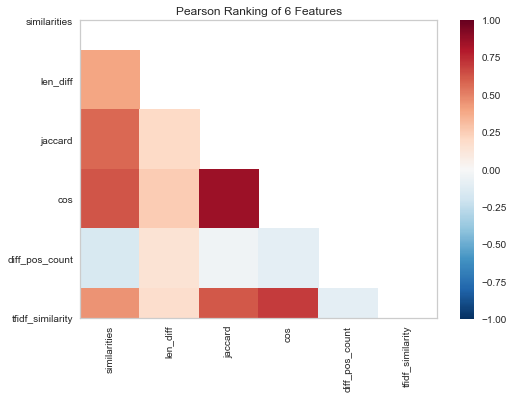

In [14]:
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import Rank2D
from yellowbrick.datasets import load_credit

# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson')

X = all_train_and_testset['pd']['x_trainset']
print(X)
X = X[['similarities','len_diff','jaccard','cos','diff_pos_count','tfidf_similarity']]

visualizer.fit(X, all_train_and_testset['pd']['y_trainset'])  
visualizer.transform(X) 
visualizer.show()
# Fit the data to the visualizer
#visualizer.transform(X)        # Transform the data
#visualizer.show()              # Finalize and render the figure         # Finalize and render the figure

#visualizer = Rank2D(algorithm="pearson")
#visualizer.fit_transform(all_train_and_testset['pd']['x_trainset'])
#visualizer.show()

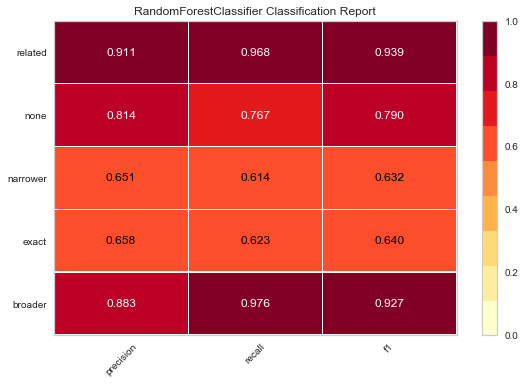

In [17]:

model = RandomForestClassifier(max_depth=15, max_features='auto', min_samples_leaf=3, min_samples_split=2, n_estimators=500)
visualizer = ClassificationReport(model)
visualizer.fit(all_train_and_testset['pd']['x_trainset'], all_train_and_testset['pd']['y_trainset'])
visualizer.score(all_train_and_testset['pd']['x_testset'], all_train_and_testset['pd']['y_testset'])
visualizer.show()

**Experiments**

In [18]:
all_data = load_training_data()
en_data = all_data['english_kd']
print(set(en_data['relation']))



{'narrower', 'none', 'broader', 'exact', 'related'}


**Add Text Classifier to the pipeline**

**Print only narrower relations**

In [19]:
#df['def1']=df['def1'].str.wrap(20)
is_narrower = en_data['relation']=='narrower'
def is_not_none(df):
    return df['relation']!='none'
def is_none(df):
    return df['relation']=='none'

print(en_data[is_not_none])

          word          pos  \
0    off        preposition   
3    off        preposition   
8    off        preposition   
13   off        preposition   
15   off        adverb        
..   ...           ...        
530  on         preposition   
551  on         preposition   
552  one        number        
553  one        number        
554  offspring  noun          

                                                    def1  \
0    away from and no longer touching                      
3    in a position away from                               
8    not inside a large vehicle used by the public         
13   not eating or taking                                  
15   away from a place                                     
..                 ...                                     
530  indicates sth or sb uses a type of food, fuel, etc.   
551  immediately following                                 
552  the number 1                                          
553  the number 1          

**Run Spacy NLP Pipeline**

In [21]:
def spacyDocForVec(sentence):
    return nlp(sentence)

en_data['processed_1'] = en_data['def1'].map(spacyDocForVec)
en_data['processed_2'] = en_data['def2'].map(spacyDocForVec)

In [22]:
from nltk import collections

en_data['processed_1']
en_data

,word,pos,def1,def2,relation,processed_1,processed_2
0,off,preposition,away from and no longer touching,away from; down from,narrower,"(away, from, and, no, longer, touching)","(away, from, ;, down, from)"
1,off,preposition,away from and no longer touching,not wanting or allowed to have (food etc),none,"(away, from, and, no, longer, touching)","(not, wanting, or, allowed, to, have, (, food, etc, ))"
2,off,preposition,away from and no longer touching,"out of (a vehicle, train etc)",none,"(away, from, and, no, longer, touching)","(out, of, (, a, vehicle, ,, train, etc, ))"
3,off,preposition,in a position away from,away from; down from,narrower,"(in, a, position, away, from)","(away, from, ;, down, from)"
4,off,preposition,in a position away from,not wanting or allowed to have (food etc),none,"(in, a, position, away, from)","(not, wanting, or, allowed, to, have, (, food, etc, ))"
...,...,...,...,...,...,...,...
551,on,preposition,immediately following,followed by,related,"(immediately, following)","(followed, by)"
552,one,number,the number 1,the number or figure 1,exact,"(the, number, 1)","(the, number, or, figure, 1)"
553,one,number,the number 1,the age of 1,related,"(the, number, 1)","(the, age, of, 1)"
554,offspring,noun,a person's child or an animal's baby,"(formal, humorous) someone's child or children",broader,"(a, person, 's, child, or, an, animal, 's, baby)","((, formal, ,, humorous, ), someone, 's, child, or, children)"


In [23]:
nlp.add_pipe(lemmatizer,name='lemmatizer',after='ner')
nlp.add_pipe(remove_stopwords, name="stopwords", last=True)

In [24]:
deps = collections.defaultdict(set)

        
def count_pos(row):
    pos = []
    for token in row['processed_1']:
        pos.append(token.pos)
        
    
    return len(list(set(pos)))
    

def filter_sw(lemmatized):
    result = []
    for token in lemmatized:
        #print(type(row))
        if token.is_stop == False:
            result.append(token)
            
    return result
    
#def lemmatize(row):
#    return ' '.join([token.lemma_ for token in row['processed_1']])


def is_lemmatized(df):
    return df['def1']!=df['lemmatized']

def lemmatizer(doc):
    # This takes in a doc of tokens from the NER and lemmatizes them. 
    # Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)
    


# The add_pipe function appends our functions to the default pipeline.


temp = pd.DataFrame()

temp['pos_count'] = en_data.apply(lambda row: count_pos(row),axis=1)


print(type(en_data['processed_1'][0]))
temp['lemmatized'] = en_data.apply(lambda row: lemmatizer(row['processed_1']),axis=1)
temp['sw_removed'] = temp['lemmatized'].map(remove_stopwords)


temp['sw_removed']


<class 'spacy.tokens.doc.Doc'>


0      [away, longer, touching]     
1      [away, longer, touching]     
2      [away, longer, touching]     
3      [position, away]             
4      [position, away]             
             ...                    
551    [immediately, follow]        
552    [number, 1]                  
553    [number, 1]                  
554    [person, child, animal, baby]
555    [person, child, animal, baby]
Name: sw_removed, Length: 556, dtype: object

55

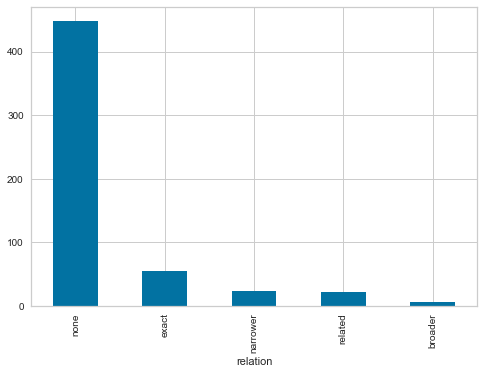

In [25]:
#modDfObj['def1'][0].sents
label_count = en_data.groupby('relation').count().word.sort_values(ascending=False)

label_count.plot(kind = 'bar')
label_count[1]
#label_count.plot(kind = 'bar', x = 'relation', y )

In [26]:
en_data.iloc[0]

word           off                                    
pos            preposition                            
def1           away from and no longer touching       
def2           away from; down from                   
relation       narrower                               
processed_1    (away, from, and, no, longer, touching)
processed_2    (away, from, ;, down, from)            
Name: 0, dtype: object

     similarities  first_word_same  len_diff   jaccard
0    0.856918      True             2         0.250000
1    0.776428      False            3         0.000000
2    0.732969      False            3         0.000000
3    0.836521      False            1         0.285714
4    0.689816      False            2         0.000000
..        ...        ...           ..              ...
551  0.615553      False            6         0.000000
552  0.915048      True             0         0.600000
553  0.822070      True             0         0.400000
554  0.850947      False            1         0.181818
555  0.934649      False            5         0.500000

[556 rows x 4 columns]


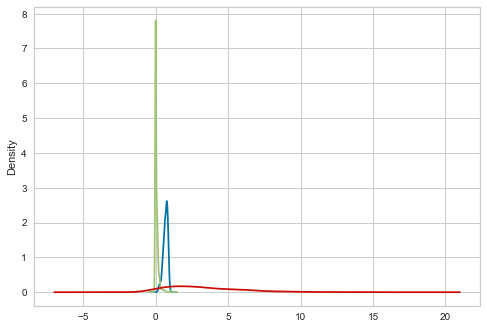

In [27]:
def sentence2vec(row):
    return row['processed_1'].similarity(row['processed_2'])

    
def first_word_same(row):
    return row['def1'].split(' ')[0].lower() == row['def2'].split(' ')[0].lower()

def difference_in_length(row):
    return abs(len(row['def1'].split(' ')) - len(row['def2'].split(' ')[0]))

def jaccard_sim(row):
    return get_jaccard_sim(row['def1'], row['def2'])


def cosine(row):
    return get_cosine_sim(row['def1'], row['def2'])[0, 1]

def get_jaccard_sim(str1, str2):
    a = set(str1.split())
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

def pos_count(column):
    pos = []
    
    for token in column:
        pos.append(token.pos)
    return list(set(pos))
        
    
def diff_pos_count(row):
    pos_def1 = pos_count(row['processed_1'])
    pos_def1 = pos_count(row['processed_2'])
    
    return  len(pos_def1) - len(pos_def1)
    


features = pd.DataFrame()

similarities = []
first_word = []
length = []

features['similarities'] = en_data.apply(lambda row: sentence2vec(row), axis = 1)
features['first_word_same'] = en_data.apply(lambda row: first_word_same(row), axis=1)
features['len_diff'] = en_data.apply(lambda row: difference_in_length(row), axis=1)
features['jaccard'] = en_data.apply(lambda row: jaccard_sim(row), axis=1)
#features['pos_diff'] = en_data.apply(lambda row: diff_pos_count(row), axis=1)
print(features)
features['similarities'].plot.kde()
features['jaccard'].plot.kde()
features['len_diff'].plot.kde()
#features['pos_diff'].plot.kde()


In [28]:
#none = features[is_none(features)==True]

#label_count = en_data.groupby('relation').count().word.sort_values(ascending=False)
#second_biggest = label_count[1]
#to_drop = none.index[second_biggest:]

#balanced = features.drop(to_drop) 
#balanced
#label_count = balanced.groupby('relation').count().similarities.sort_values(ascending=False)

#label_count.plot(kind = 'bar')
#label_count[1]
#second_biggest
#label_count.plot(kind = 'bar')



In [29]:
#en_data['similarities'] = similarities
labels = en_data['relation']
#features = features.drop(['relation'], axis=1)
features

,similarities,first_word_same,len_diff,jaccard
0,0.856918,True,2,0.250000
1,0.776428,False,3,0.000000
2,0.732969,False,3,0.000000
3,0.836521,False,1,0.285714
4,0.689816,False,2,0.000000
...,...,...,...,...
551,0.615553,False,6,0.000000
552,0.915048,True,0,0.600000
553,0.822070,True,0,0.400000
554,0.850947,False,1,0.181818


**Split Dataset**

,similarities,first_word_same,len_diff,jaccard
200,0.526539,False,0,0.000000
68,0.528048,False,1,0.000000
493,0.494418,False,3,0.000000
285,0.305741,False,2,0.000000
399,0.692911,False,3,0.000000
...,...,...,...,...
331,0.871553,False,6,0.062500
235,0.550701,False,1,0.000000
75,0.836951,True,5,0.142857
92,0.579219,False,2,0.000000


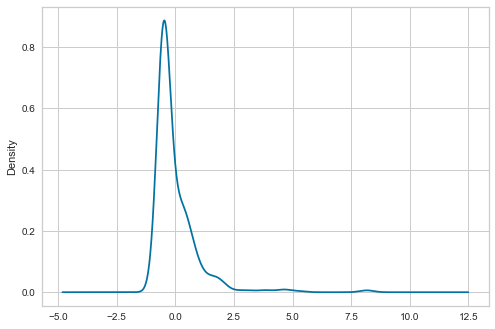

In [30]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2)
X_train_scaled = X_train.copy(deep = True)
X_test_scaled = X_test.copy(deep = True)

X_train_scaled['similarities'] = preprocessing.scale(X_train['similarities'])
X_train_scaled['len_diff'] = preprocessing.scale(X_train['len_diff'])
X_train_scaled['jaccard'] = preprocessing.scale(X_train['jaccard'])
#X_train_scaled['length'] = preprocessing.scale(X_train['length'])
#X_test_scaled['similarities'] = preprocessing.scale(X_test['similarities'])
#X_test_scaled['length'] = preprocessing.scale(X_test['length'])
#features['similarities'].plot.kde()
#X_train_scaled['similarities'].plot.kde()
X_train_scaled['jaccard'].plot.kde()
#X_train_scaled['len_diff'].plot.kde()

X_train_set = {}
X_train_set['unscaled'] = X_train
X_train_set['scaled'] = X_train_scaled

X_test_set = {}
X_test_set['unscaled'] = X_test
X_test_set['scaled'] = X_test_scaled

X_test_set['unscaled']


In [64]:
def get_baseline(test_set):
    TP = 0
    for index in test_set.index:
        if test_set[index]=='none':
            TP+=1

    return float(TP/len(test_set))


def run_cv_with_dataset(model, trainset, y_train):
    scores = cross_val_score(model, trainset, y_train, cv = 5)        
    print('Cross validation scores for model' + model.__class__.__name__)
    #scores
    print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

def cross_val_models(models, all_training_set, y_train):
    for estimator in models['unscaled']:
        run_cv_with_dataset(estimator, all_training_set['unscaled'], y_train)
    
    for estimator in models['scaled']:
        run_cv_with_dataset(estimator, all_training_set['scaled'], y_train)

def compare_on_testset(models, testset_x, testset_y, testset_x_scaled):
    print('Model Evaluation on Testset: ' + '\n')
    print('\t' + 'BASELINE: ' + str(get_baseline(testset_y)) + '\n')
    
    for estimator in models['unscaled']:
        estimator.predict(testset_x)
        print('\t' + estimator.__class__.__name__)
        score = estimator.score(testset_x, testset_y)
        print('\t\t' + "Accuracy: %0.4f (+/- %0.4f)" % (score.mean(), score.std() * 2) + '\n')
    
    for estimator in models['scaled']:
        estimator.predict(testset_x_scaled)
        print('\t' + estimator.__class__.__name__)
        score = estimator.score(testset_x_scaled, testset_y)
        print('\t\t' + "Accuracy for scaled featureset: %0.4f (+/- %0.4f)" % (score.mean(), score.std() * 2) + '\n')

def train_models(X_train, y_train, X_train_scaled):
    print('baseline: ', str(get_baseline(y_test)) + '\n')

    LR = LogisticRegression( solver = 'lbfgs', multi_class = 'multinomial').fit(X_train, y_train)
    LR_scaled = LogisticRegression( solver = 'lbfgs', multi_class = 'multinomial').fit(X_train_scaled, y_train)

    ## Linear kernal won't work very well, experiment with nonlinear ones.
    SVM = svm.LinearSVC(C=10.0).fit(X_train, y_train)
    SVM_scaled = svm.LinearSVC().fit(X_train_scaled, y_train)

    RF = RandomForestClassifier(max_depth = 5, random_state=0).fit(X_train, y_train)
    RF_scaled = RandomForestClassifier(max_depth = 5, random_state=0).fit(X_train_scaled, y_train)
    
    models = {}
    models['unscaled'] = [LR, SVM, RF]
    models['scaled'] = [LR_scaled, SVM_scaled, RF_scaled]
    
    return models

models = train_models(X_train, y_train, X_train_scaled)
cross_val_models(models, X_train_set, y_train)
#print(models)
compare_on_testset(models, X_test, y_test, X_test_scaled)


baseline:  0.7857142857142857



C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\s

Cross validation scores for modelLogisticRegression
Accuracy: 0.8224 (+/- 0.0373)


C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: C

Cross validation scores for modelLinearSVC
Accuracy: 0.8157 (+/- 0.0440)
Cross validation scores for modelRandomForestClassifier
Accuracy: 0.8133 (+/- 0.0611)
Cross validation scores for modelLogisticRegression
Accuracy: 0.8156 (+/- 0.0381)


C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\syim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: C

Cross validation scores for modelLinearSVC
Accuracy: 0.8179 (+/- 0.0419)
Cross validation scores for modelRandomForestClassifier
Accuracy: 0.8133 (+/- 0.0611)
Model Evaluation on Testset: 

	BASELINE: 0.7857142857142857

	LogisticRegression
		Accuracy: 0.7857 (+/- 0.0000)

	LinearSVC
		Accuracy: 0.7768 (+/- 0.0000)

	RandomForestClassifier
		Accuracy: 0.7857 (+/- 0.0000)

	LogisticRegression
		Accuracy for scaled featureset: 0.7857 (+/- 0.0000)

	LinearSVC
		Accuracy for scaled featureset: 0.7857 (+/- 0.0000)

	RandomForestClassifier
		Accuracy for scaled featureset: 0.7857 (+/- 0.0000)

